In [64]:
import numpy as np
from scipy.stats import norm

def get_data(n,mu=0):
    X = np.random.normal(mu,1,size=n)
    return X

def get_random_split(X, b):
    rows_id = np.random.choice(np.arange(len(X)), b, replace=False)
    return X[rows_id]

def pval(Xb):
    test_stats = np.mean(Xb)
    rv = norm(scale=np.sqrt(1/len(Xb)))
    pval = (1-rv.cdf(test_stats))*2
    return pval

def one_trial(n, b, M, G, mu=0, alpha=0.05):
    X = get_data(n, mu=mu)
    pvals = [pval(get_random_split(X, b)) for i in range(M)]
    pvals_mean = np.mean(pvals)
    # romano's method
    test_romano = 1 if pvals_mean < alpha/2 else 0
    # randomization
    pvals_T = np.zeros(G)
    for i in range(G):
        g = np.random.choice([-1,1],n)
        gX = g*X
        pvals_T[i] = np.mean([pval(get_random_split(gX, b)) for i in range(M)])
    test_randomization = 1 if np.mean(pvals_T<pvals_mean) < alpha else 0
    # approximate randomization
    pvals_Ta = np.zeros(G)
    for i in range(G):
        g = np.random.choice([-1,1],M)
        S = np.array(pvals)
        S[g==-1] = 1 - S[g==-1]
        pvals_Ta = np.mean(S)
    test_approx_rand = 1 if np.mean(pvals_Ta<pvals_mean) < alpha else 0
    return test_romano, test_randomization, test_approx_rand

def simulation(n, b, M, G, mu=0, alpha=0.05, ntrials=100):
    tests = np.zeros((ntrials,3))
    for i in range(ntrials):
        tests = np.array(one_trial(n, b, M, G, mu, alpha))
        print(tests)
    return np.mean(tests, axis=0)

In [65]:
simulation(1000, 500, 200, 200)

[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]


KeyboardInterrupt: 

0.945 1.0529100166439957


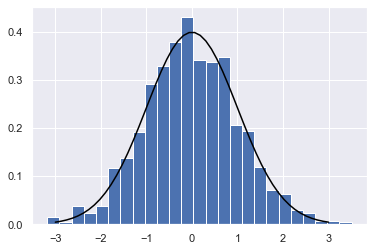

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from winners import DGP, RD
sns.set_theme()

tstats, covers = [], []
for i in range(1000):
    dgp = DGP(1000, 5, np.arange(5), np.ones(5))
    Y, Z = dgp.get_data()
    rd = RD(Y, Z, 500)
    mean, se, _, cf = rd.sampel_splitting()
    t = (mean-4)/se
    tstats.append(t)
    cover = 1 if cf[0] <= 4 <= cf[1] else 0
    covers.append(cover)
    
plt.hist(tstats, bins='auto', density=True)
x = np.linspace(-3,3)
pdf = norm.pdf(x)
plt.plot(x, pdf, color='black')
print(np.mean(covers), np.var(tstats))

  0%|          | 0/500 [00:00<?, ?it/s]

0.052


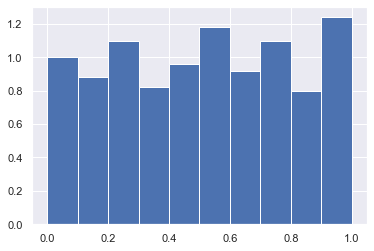

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from winners import DGP, RD
from tqdm.notebook import tqdm
sns.set_theme()

pvalues = []
ntrials = 500
sample_size = 1000
ntests = 5
ntrans = 100
for i in tqdm(range(ntrials)):
    dgp = DGP(sample_size, 5, np.arange(5)-4, np.ones(5))
    Y, Z = dgp.get_data()
    rd = RD(Y, Z, int(len(Z)/2))
    pvalue = rd.multiple_test(ntests,ntrans)
    pvalues.append(pvalue)
pvalues = np.array(pvalues)

print(np.mean(pvalues <= 0.05))
plt.hist(pvalues, bins='auto', density=True)
plt.show()

In [2]:
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("num_cores={}".format(num_cores))

def simulation(ntrials, sample_size, ntests, ntrans):
    def process():
        dgp = DGP(sample_size, 5, np.arange(5)-4, np.ones(5))
        Y, Z = dgp.get_data()
        rd = RD(Y, Z, int(len(Z)/2))
        pvalue = rd.multiple_test(ntests,ntrans)
        return pvalue
    pvalues = Parallel(n_jobs=num_cores)(delayed(process)() for _ in range(ntrials))
    pvalues = np.array(pvalues)
    return pvalues

ntrials = 500
sample_size = 5000
ntrans = 500
num_tests = [1,2,3,4,5,10,20]
for ntests in num_tests:
    pvalues = simulation(ntrials, sample_size, ntests, ntrans)
    reject_prob = np.mean(pvalues <= 0.05)
    with open("output_small.txt", "a") as f:
        print('estimated mu, ntrials={}, sample size={}, ntests={}, ntrans={}: '.format(ntrials, sample_size,ntests,ntrans)
        ,reject_prob, file=f)

num_cores=8
